In [41]:
# Setup
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import time
import matplotlib.pyplot as plt
import warnings
import torch.nn as nn
import spacy
from anchor import anchor_text
import pickle
import models 
import training 
import plot 
from utils import *

SEED = 84
torch.manual_seed(SEED)
warnings.simplefilter("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
plt.rcParams['font.size'] = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [45]:
review_parser = None
label_parser = None
ds_train = None
ds_valid = None
ds_test = None
from dataset_loader import *
review_parser, label_parser, ds_train, ds_valid= spam_dataset('../dataset/spam.csv')

747
4825
Number of tokens in training samples: 2690
Number of tokens in training labels: 2


## Forward Function For Getting Accuracy

In [46]:
len(ds_train)

1000

In [47]:
import tqdm
def forward_dl(model, dl, device, type_dl):
    model.train(False)
    num_samples = len(dl) * dl.batch_size
    num_batches = len(dl)  
    pbar_name = type(model).__name__
    list_y_real = []
    list_y_pred = []
    pbar_file = sys.stdout
    num_correct = 0
    dl_iter = iter(dl)
    for batch_idx in range(num_batches):
        data = next(dl_iter)
        x, y = data.text, data.label
        list_y_real.append(y)
        x = x.to(device)  # (S, B, E)
        y = y.to(device)  # (B,)
        with torch.no_grad():
            if isinstance(model, models.VanillaGRU):
                y_pred_log_proba = model(x)
            elif isinstance(model, models.MultiHeadAttentionNet):
                y_pred_log_proba, _ = model(x)
            y_pred = torch.argmax(y_pred_log_proba, dim=1)
            num_correct += torch.sum(y_pred == y).float().item()
            list_y_pred.append(y_pred)
    accuracy = 100.0 * num_correct / num_samples
    print(f'Accuracy for {type_dl} is {accuracy}')
    
    all_y_real = torch.cat(list_y_real)
    all_y_pred = torch.cat(list_y_pred)
    return all_y_real, all_y_pred, accuracy

# Training Function

### Saves all the the output in the output directory

In [48]:
import torch.optim as optim
import numpy as np
import pandas as pd
from pathlib import Path
def train_model(model_name, device, output_directory = 'results'):
    NUM_EPOCHS = 100
    if model_name == 'gru':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.VanillaGRU(review_parser.vocab, hp['embedding_dim'], hp['hidden_dim'], hp['num_layers'], hp['output_classes'], hp['dropout']).to(device)
    elif model_name == 'attention':
        hp = load_hyperparams(model_name, type_dataset)
        model = models.MultiHeadAttentionNet(input_vocabulary=review_parser.vocab, embed_dim=hp['embedding_dim'], num_heads=hp['num_heads'], 
                                           dropout=hp['dropout'], two_attention_layers=hp['two_atten_layers'], output_classes=hp['output_classes']).to(device)
    print(model)
    dl_train, dl_valid = torchtext.legacy.data.BucketIterator.splits((ds_train, ds_valid), batch_size=hp['batch_size'], sort = False, shuffle=True, device=device)
    
    optimizer = optim.Adam(model.parameters(), lr=hp['lr'])
    loss_fn = nn.NLLLoss()
    
    trainer = training.SentimentTrainer(model, loss_fn, optimizer, device)
    checkpoint_filename = str(output_directory) +  '/' + model_name
    print(f'Saving checkpoint with prefix: {checkpoint_filename}')
    fit_res = trainer.fit(dl_train, dl_valid, NUM_EPOCHS, early_stopping = hp['early_stopping'], checkpoints = checkpoint_filename, params = hp)
    
    fig, axes = plot.plot_fit(fit_res)
    fig.savefig(output_directory + '/' + str(model_name + '.png'))

    saved_state = torch.load(checkpoint_filename + '.pt', map_location=device)
    model.load_state_dict(saved_state["model_state"])
    loaded_hp = saved_state["parameters"]
    print('----- Loaded params ------')
    print(loaded_hp)
    all_dataloaders = [dl_train, dl_valid]
    type_dls = ['train', 'valid', 'test']
    accuracies = []
    for dl, type_dl in zip(all_dataloaders, type_dls):
        y_real, y_pred, accuracy = forward_dl(model, dl, device, type_dl)
        df = compute_confusion_matrix(y_real, y_pred, model_name, type_dl)
        accuracies.append(accuracy)
        display(df)
    numpy_accuracy = np.array(accuracies)
    df = pd.DataFrame(numpy_accuracy, index = type_dls, dtype=float)
    df.to_csv(output_directory + '/' + str('accuracies_' + model_name + '.csv')) 

# Training GRU

{'embedding_dim': 100, 'batch_size': 32, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.3, 'lr': 5e-05, 'early_stopping': 5, 'output_classes': 2}
VanillaGRU(
  (embedding_layer): Embedding(2690, 100)
  (GRU_layer): GRU(100, 256, num_layers=2, dropout=0.3)
  (dropout_layer): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)
Saving checkpoint with prefix: spam/gru
--- EPOCH 1/100 ---
train_batch (Avg. Loss 0.694, Accuracy 48.340): 100%|█| 32/32 [00:00<00:00, 110.95i
test_batch (Avg. Loss 0.691, Accuracy 48.633): 100%|█| 16/16 [00:00<00:00, 284.27it
*** Saved checkpoint spam/gru.pt at epoch 1
--- EPOCH 2/100 ---
train_batch (Avg. Loss 0.690, Accuracy 54.883): 100%|█| 32/32 [00:00<00:00, 137.80i
test_batch (Avg. Loss 0.689, Accuracy 63.281): 100%|█| 16/16 [00:00<00:00, 289.72it
*** Saved checkpoint spam/gru.pt at epoch 2
--- EPOCH 3/100 ---
train_batch (Avg. Loss 0.688, Accuracy 54.199): 100%|█| 32/32 [00:00<00:0

NameError: name 'compute_confusion_matrix' is not defined

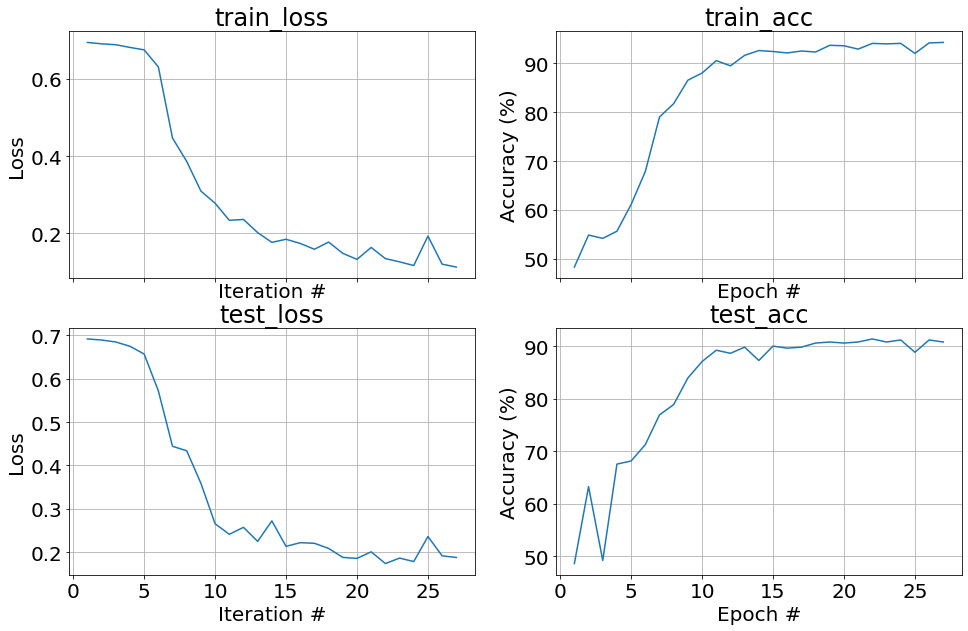

In [49]:
SEED = 84
torch.manual_seed(SEED)
train_model('gru', device, output_directory='spam')

# Training Attention

In [ ]:
SEED = 84
torch.manual_seed(SEED)
#train_model('attention', device)